In [1]:
import pandas as pd
import os

In [164]:
from sklearn.metrics import silhouette_samples,silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [165]:
betas_train_path = '../data/processed/concatenated_data_pq/split_0/betas_train.pq'
se_train_path = '../data/processed/concatenated_data_pq/split_0/se_train.pq'

betas_val_path = '../data/processed/concatenated_data_pq/split_0/betas_validate.pq'
se_val_path = '../data/processed/concatenated_data_pq/split_0/se_validate.pq'

In [ ]:
# plt.scatter(y=betas_df[beta_cols].iloc[10].values/se_df[se_cols].iloc[10].values,x=beta_cols)
plt.errorbar(y=betas_df[beta_cols].iloc[10],x=beta_cols,yerr=se_df[se_cols].iloc[10])
# plt.scatter(y=betas_df[beta_cols].iloc[10].values,x=beta_cols)

<ErrorbarContainer object of 3 artists>

In [166]:
# read training parquets
betas_df = pd.read_parquet(betas_train_path)
index_order = betas_df.index
betas_df = betas_df.loc[index_order]
beta_cols = [v for v in betas_df.columns if 'beta' in v]

se_df = pd.read_parquet(se_train_path)
se_df = se_df.loc[index_order]
se_cols = [v for v in se_df.columns if 'se' in v]

# --------

# read validation parquets
betas_df_val = pd.read_parquet(betas_val_path)
index_order_val = betas_df_val.index
betas_df_val = betas_df_val.loc[index_order_val]

se_df_val = pd.read_parquet(se_val_path)
se_df_val = se_df_val.loc[index_order_val]

In [167]:
def get_bootstrap_sample(betas_df,se_df,beta_cols,se_cols):
    train_sample = np.random.normal(loc=betas_df[beta_cols], scale=se_df[se_cols])
    y = betas_df['cluster_num'].values
    return train_sample,y

def summarize_bootstrap_lst(bootstrap_outs_lst):
    return {'mean' : np.mean(bootstrap_outs_lst), 'std' : np.std(bootstrap_outs_lst)}

In [168]:
bootstrap_tot_iters = 100
tot_cluster_num = betas_df['cluster_num'].nunique()

In [ ]:
sil_score_lst = []

# set old, new beta and se vals
betas_old_df = betas_df.copy()
se_old_df = se_df.copy()

betas_new_df = betas_df.copy()
se_new_df = se_df.copy()

metric_tracking = []

for new_cluster_point in betas_df_val.index[:10]:
    
    # print(new_cluster_point)

    new_pt_ground_truth = betas_df_val.loc[new_cluster_point,'cluster_num'].copy()

    # add new point to the new df from validation dataframe
    betas_new_df.loc[new_cluster_point] = betas_df_val.loc[new_cluster_point]
    se_new_df.loc[new_cluster_point] = se_df_val.loc[new_cluster_point]

    # add cluster assignment
    assigned_cluster = np.int64(np.random.randint(tot_cluster_num))

    betas_new_df.loc[new_cluster_point,'cluster_num'] = assigned_cluster
    se_new_df.loc[new_cluster_point,'cluster_num'] = assigned_cluster
    
    bootstrap_metric_lst = []

    for num_sample in range(bootstrap_tot_iters):

        # bootstrap a training sample:
        train_sample_old,y_old = get_bootstrap_sample(betas_old_df, se_old_df,beta_cols,se_cols)

        train_sample_new,y_new = get_bootstrap_sample(betas_new_df, se_new_df,beta_cols,se_cols)

        # add scaling and transformations here if needed

        # compute & track the metric
        metric_val = 0

        bootstrap_metric_lst.append(metric_val)


    metric_tracking.append(summarize_bootstrap_lst(bootstrap_metric_lst))

    betas_old_df = betas_new_df.copy()
    se_old_df = se_new_df.copy()

    # break

In [176]:
metric_df = pd.DataFrame(metric_tracking)

In [189]:
# plt.scatter(x=metric_df.index,y=metric_df['mean'],color='c')
# plt.errorbar(x=metric_df.index,y=metric_df['mean'], yerr=metric_df['std'], fmt="o")

In [ ]:
# X_sample
# betas_df / 
# se_df

In [4]:
# cv is nan only for cluster 0
betas_df[betas_df['cv_idx'].isna()]['cluster_num'].unique()

array([0])

In [66]:
score = silhouette_score(X_scaled, y)
print(f"Silhouette Score (original features): {score:.4f}")

score_pca = silhouette_score(X_pca[:, :10], y)
print(f"Silhouette Score (PCA-10D): {score_pca:.4f}")

score_lda = silhouette_score(X_lda, y)
print(f"Silhouette Score (LDA): {score_lda:.4f}")

Silhouette Score (original features): -0.4393
Silhouette Score (PCA-10D): -0.4881
Silhouette Score (LDA): 0.8307


/tmp/ipykernel_42979/3835358110.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_num', y='silhouette_score', data=df_sil, palette='tab20')


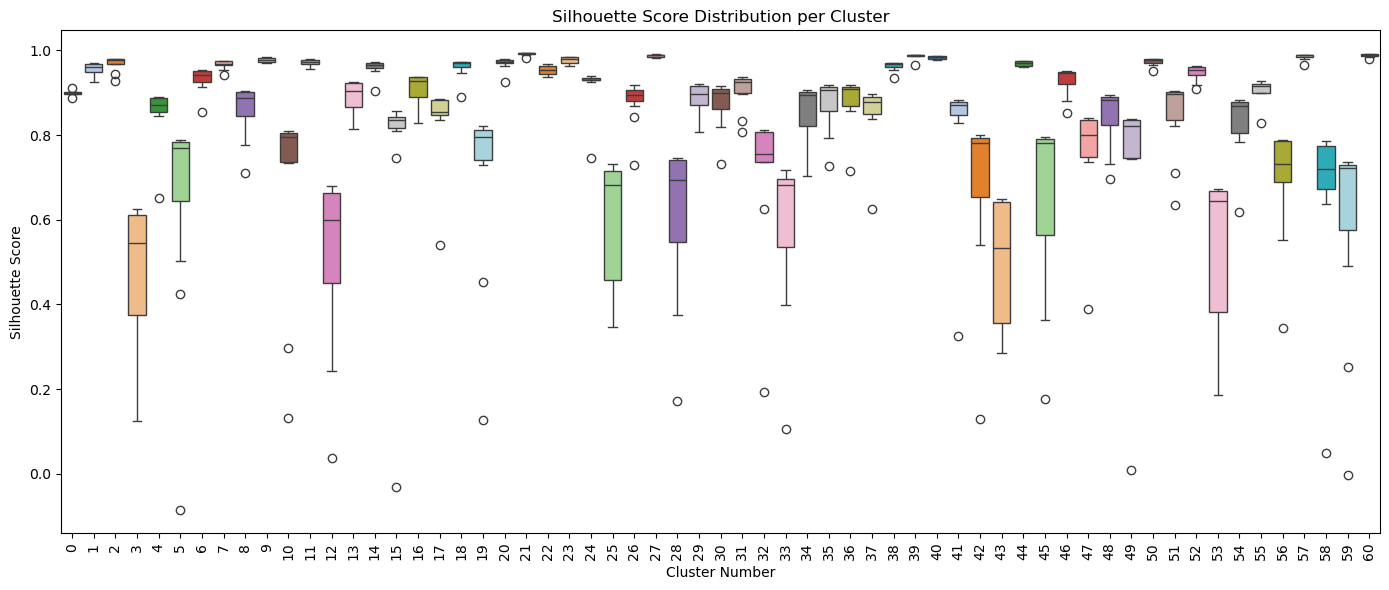

/tmp/ipykernel_42979/3835358110.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster_num', y='silhouette_score', data=mean_sil, palette='tab20')


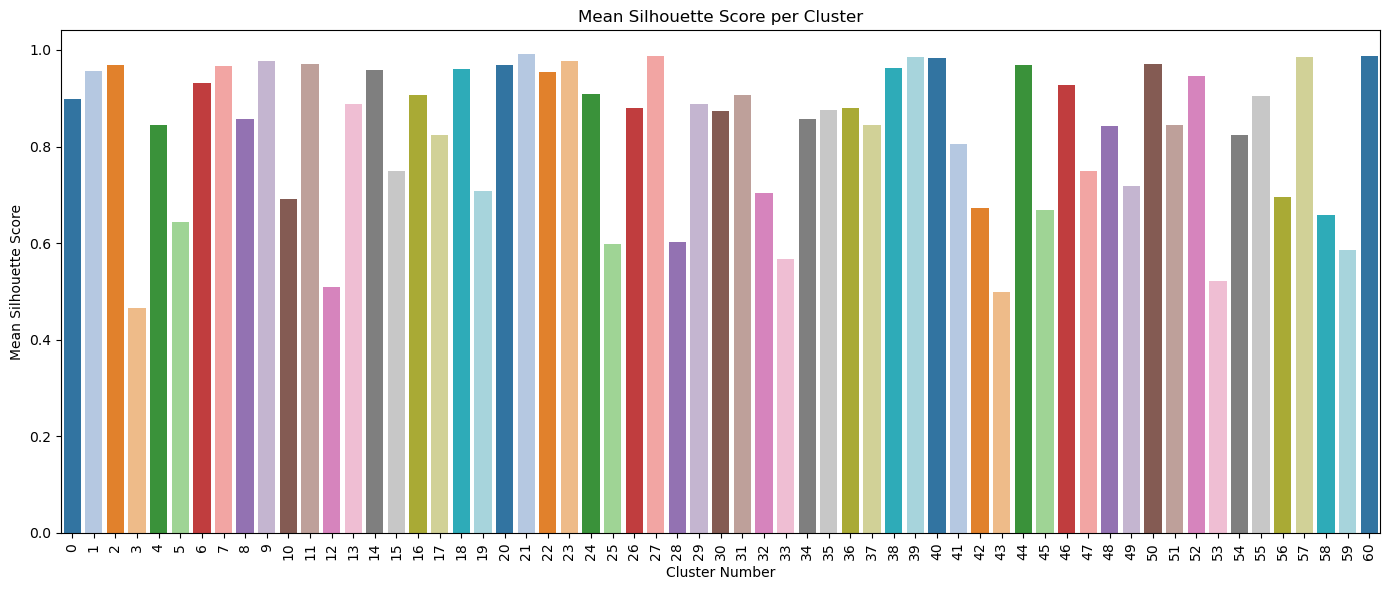

In [ ]:

# Assume you have:
# - X_scaled: scaled features
# - labels: cluster labels (df['cluster_num'])

# 1. Compute silhouette scores for each sample
sil_scores = silhouette_samples(X_lda, y)

# 2. Create DataFrame for plotting
df_sil = pd.DataFrame({
    'cluster_num': y,
    'silhouette_score': sil_scores
})

# 3. Calculate mean silhouette per cluster (optional)
mean_sil = df_sil.groupby('cluster_num')['silhouette_score'].mean().reset_index()

# 4. Plot distribution per cluster (boxplot)
plt.figure(figsize=(14, 6))
sns.boxplot(x='cluster_num', y='silhouette_score', data=df_sil, palette='tab20')
plt.xticks(rotation=90)
plt.xlabel('Cluster Number')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Distribution per Cluster')
plt.tight_layout()
plt.show()

# 5. (Optional) Plot mean silhouette per cluster as barplot
plt.figure(figsize=(14, 6))
sns.barplot(x='cluster_num', y='silhouette_score', data=mean_sil, palette='tab20')
plt.xticks(rotation=90)
plt.xlabel('Cluster Number')
plt.ylabel('Mean Silhouette Score')
plt.title('Mean Silhouette Score per Cluster')
plt.tight_layout()
plt.show()


In [56]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

feature_cols = [v for v in betas_df.columns if 'beta' in v]
X = betas_df[feature_cols]
y = betas_df['cluster_num'].values

# 2. Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. LDA
lda = LinearDiscriminantAnalysis(n_components=len(np.unique(y)) - 1)
X_lda = lda.fit_transform(X_scaled, y)  # shape: (n_samples, n_components)


In [50]:
# y

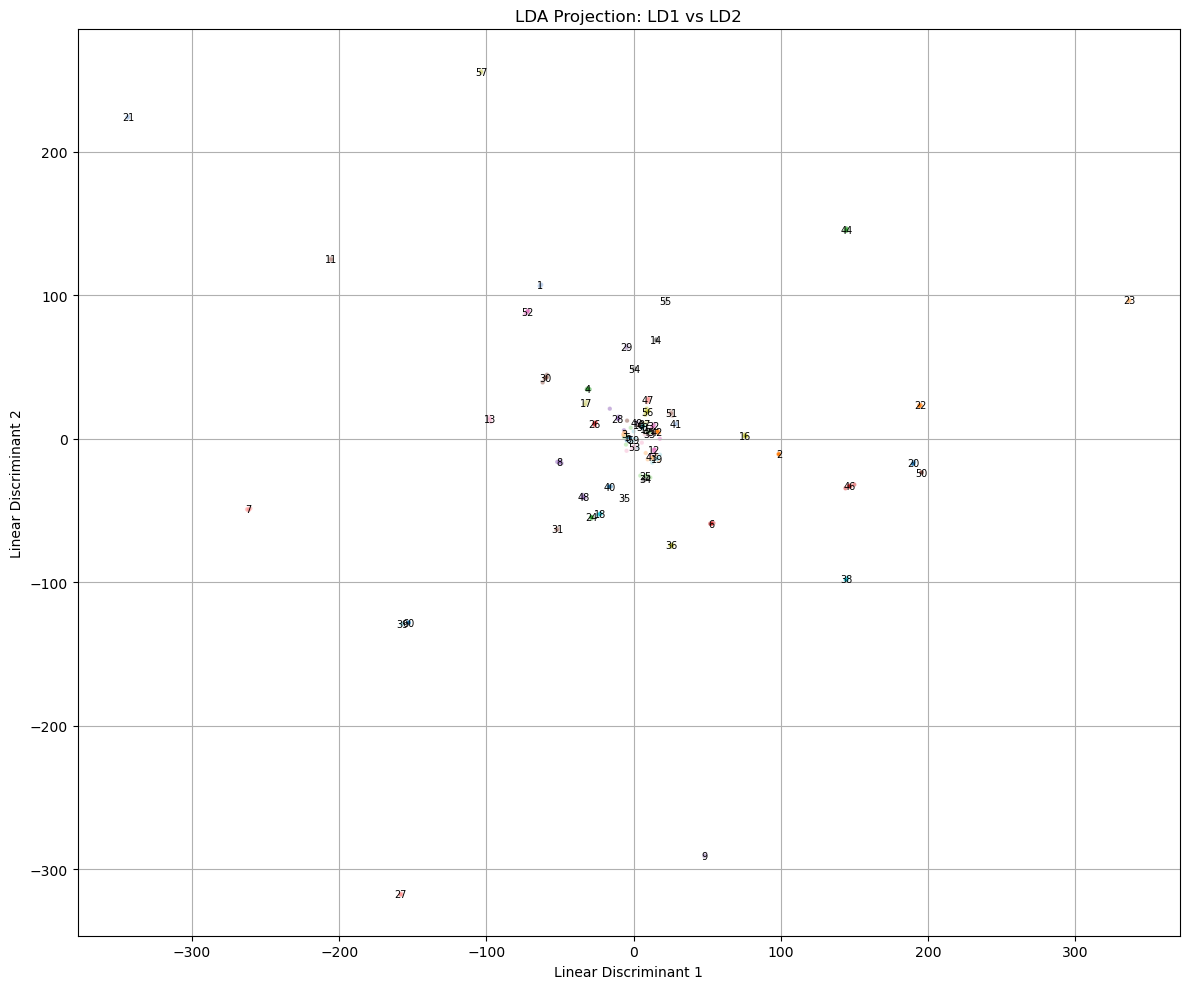

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame for plotting
df_lda = pd.DataFrame(X_lda[:, :2], columns=['LD1', 'LD2'])
df_lda['cluster_num'] = y

# Plot with centroids
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_lda, x='LD1', y='LD2', hue='cluster_num', palette='tab20', s=10, legend=False, alpha=0.5)

# Add centroids
centroids_lda = df_lda.groupby('cluster_num')[['LD1', 'LD2']].mean()
for cluster_id, (ld1, ld2) in centroids_lda.iterrows():
    plt.text(ld1, ld2, str(cluster_id), fontsize=7, ha='center', va='center')

plt.title('LDA Projection: LD1 vs LD2')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.grid(True)
plt.tight_layout()
plt.show()
